# Compile list of unique genes from intermediate_data_01

## Workflow

1. Loop through each dataset from `data/intermediate_data_01/`
2. For each dataset,
    - collect list of unique genes and associated candidate gene label
    - `included` =  the number of times the gene is assigned as candidate gene
    - `total_comparisons` = the number of comparisons (`fold_difference` or `protein_fold_difference`) for each gene. Computationally, this is the number of rows of data for that gene.
    - append `gene_id`, `included`, `total_comparisons`, `firstauthor_year` to dictionary `matches` or `mismatches` depending on whether the `gene_id` has a match in query output `gene_info.csv`.
3. Export `matches`, `mismatches`, and `problems` using `pickle`

In [56]:
import pandas as pd
import numpy as np
import os
import re
import warnings
import time
import pickle

ImportError: No module named 'sklearn'

In [2]:
current_dir = os.getcwd()
gene_info = pd.read_csv("../../data/intermediate_data_02/gene_info.csv", delimiter = ",")
print(gene_info[:5])

         gene_id   secondaryid gene_name
0  Cre06.g261000  PAC:30779314      PSBR
1  Cre10.g452450  PAC:30790862    CIM110
2  Cre06.g302050  PAC:30779788       NaN
3  Cre03.g183700  PAC:30786959       NaN
4  Cre03.g185000  PAC:30787114       NaN


# Create empty dictionaries to store genes that match the query and don't match the query
Dictionary structure

`matches = {gene_id: { firstauthor_year : [included,total] }`

In [46]:
matches = {}
mismatches = {}
problems = pd.DataFrame()
match_summary = pd.DataFrame(columns = ["first_author", "year",'matches', 'mismatches','problems', 'total'])

In [49]:
matches = {}
mismatches = {}
problems = pd.DataFrame()
match_summary = pd.DataFrame(columns = ["first_author", "year",'matches', 'mismatches','problems', 'total'])

#Loop through firstauthor_year.txt files in intermediate_data_01
#path = "../../data/intermediate_data_01/"
os.chdir("../../data/intermediate_data_01/")
t0 = time.time()
for file in os.listdir(os.getcwd()):
    #print(file)
    if file.endswith(".txt"):
        df = pd.read_csv(file, delimiter = "\t")
        total_genes, num_matches, num_mismatches, num_problems = [0]*4
    else: continue
    #if df['gene_id'].empty == False:
    #Loop through each unique gene in dataset
    if not ('gene_id' in list(df.columns)) or (file == "basic_info.txt"): 
        continue
    
    first_author = source.split("_")[0]
    publication_year = source.split("_")[1]
    source = file.split(".")[0]
    print(source)
    
    for gene in np.unique(df['gene_id']):
    #count +=1
    #if count >50: break
        total_genes +=1
    #create temporary working dataframe
        temp = df[df.gene_id == gene]
    
    #Get the number of total comparisons and number of comparisons qualifying candidate gene criteria
        total_comparisons = len(temp)
        included = len(temp[temp.candidate_gene == True])
  
    #Generate output in dictionary format
        
        output = [":".join([source,str(included),str(total_comparisons)])]
    
        geneName = None
    
    #Add gene to problems dataframe to keep track of unique genes with more than one gene_names
    #Track number of problem genes
        try:         
            if len(pd.unique(temp['gene_name'])) > 1: 
                num_problems +=1
                warnings.warn("Unique gene has more than one gene_name")
                temp['source'] = [source]*len(temp)
                problems = problems.append(temp, ignore_index = True)
                continue
        
    #Set geneName as the first unique gene_name in the temporary df that contains only one gene_id
            if len(pd.unique(temp['gene_name'])) == 1:
                geneName = pd.unique(temp['gene_name'])[0]
        except KeyError: geneName = None

        
    #Find gene_id matches in "gene_name" and "secondaryid"
        match = False
        
    #See if gene exists in matches/mismatches dictionaries already
        if gene in matches.keys(): 
            matches[gene].append(output)
            num_matches +=1
        
        elif gene in mismatches.keys(): 
            mismatches[gene].append(output)
            num_mismatches +=1
        
    #If gene does not exist in matches/mismatches dictionaries, search in gene_info
    #if match found, rename gene as primaryIdentifier
    
    #Find gene_id matches in "gene_name" and "secondaryid" from downloaded gene_info
        elif gene in list(gene_info['gene_id']): 
            gene = gene_info[gene_info.gene_id==gene]
            match = True
  
        elif gene in list(gene_info['secondaryid']):
            gene = gene_info[gene_info.secondaryid==gene]
            match = True
        
    #Find questionable gene_name matches in "gene_name"
        elif (geneName!= None) & (geneName in list(gene_info['gene_name'])):
            gene = gene_info[gene_info.gene_name==geneName]
            match = True
        
    #At this point, the only possibility is the gene does not have a match in Phytozyme
    #Add to mismatches dictionary if cannot find matching gene id/name in qeary results (gene_info)
        else:
            mismatches[str(gene)] = list(output)
            num_mismatches +=1
            continue
    
    #Add to matches dictionary if find matching gene id/name in query results (gene_info)
        if match == True:
            gene.index = pd.RangeIndex(len(gene.index))
            if gene.empty != True:
                gene = gene.iloc[0,0]
                matches[str(gene)] = list(output)
                num_matches +=1
            else: 
                num_problems +=1
                temp['source'] = [source]*len(temp)
                problems = problems.append(temp, ignore_index = True)
                continue
                
    #Give a warning if loop fails to assign all genes to appropriate dictionaries/dataframes
    if total_genes != num_matches + num_mismatches + num_problems:
        print(file)
        warnings.warn(" ".join([source,"did not capture all genes"]))
        
    match_summary = match_summary.append(pd.Series(
                                                    [first_author, publication_year, num_matches, num_mismatches, num_problems, len(np.unique(df['gene_id']))], 
                                                    index = match_summary.columns), 
                                            ignore_index=True)
        
t1= time.time()
total = t1-t0
print(total)  

Hemme_2014


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: Unique gene has more than one gene_name
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Bajhaiya_2016
Goodenough_2014
Blaby_2013


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Boyle_2012
Juergens_2015
Kwak_2017
Gargouri_2015
156.79244232177734


## Show summary of matches, mismatches, and problems

In [52]:
match_summary['proportion_of_matches'] = match_summary['matches']/match_summary['total']

In [53]:
print("Number of matches:", len(matches))
print(list(matches.items())[:5])

print("Number of mismatches:", len(mismatches))
print(list(mismatches.items())[:5])

print("Number of Problems:", len(pd.unique(problems['gene_id'])))
#print (problems[:5])
print(match_summary)

Number of matches: 12287
[('Cre10.g444100', ['Bajhaiya_2016:0:4']), ('Cre03.g172750', ['Bajhaiya_2016:1:4']), ('Cre01.g049500', ['Hemme_2014:0:1', ['Kwak_2017:0:2']]), ('Cre08.g365400', ['Hemme_2014:0:1', ['Bajhaiya_2016:3:4'], ['Kwak_2017:1:2']]), ('Cre10.g458250', ['Bajhaiya_2016:0:4'])]
Number of mismatches: 6343
[('g9822', ['Bajhaiya_2016:0:4']), ('g16557', ['Bajhaiya_2016:0:4']), ('g2883', ['Bajhaiya_2016:0:4']), ('g12048', ['Bajhaiya_2016:0:4']), ('g2487', ['Bajhaiya_2016:0:4'])]
Number of Problems: 130
  first_author  year  matches  mismatches  problems    total  \
0     Gargouri  2015   1623.0       353.0       3.0   1979.0   
1        Hemme  2014  11763.0      5974.0       0.0  17737.0   
2     Bajhaiya  2016     57.0        11.0       0.0     68.0   
3   Goodenough  2014    470.0        45.0     127.0    642.0   
4        Blaby  2013     21.0         4.0       0.0     25.0   
5        Boyle  2012     80.0        25.0       0.0    105.0   
6     Juergens  2015    757.0        

## Export to intermediate_data_02

In [54]:
pickle_out = open("../../data/intermediate_data_02/matches", "wb")
pickle.dump(matches, pickle_out)
pickle_out.close()

pickle_out = open("../../data/intermediate_data_02/mismatches", "wb")
pickle.dump(mismatches, pickle_out)
pickle_out.close()

problems.to_csv("../../data/intermediate_data_02/problems.csv", index = False)

match_summary.to_csv("../../data/intermediate_data_02/match_summary.csv", index = False)


## Visualize summary

#### What is the distribution of matches among the papers?
- Is the proportion of matches related to year of publication?

Save figure output to `analysis/generate_intermediate_data_02/` folder

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
os.chdir(current_dir)

Index(['first_author', 'year', 'matches', 'mismatches', 'problems', 'total',
       'proportion_of_matches'],
      dtype='object')
first_author              object
year                       int64
matches                  float64
mismatches               float64
problems                 float64
total                    float64
proportion_of_matches    float64
dtype: object


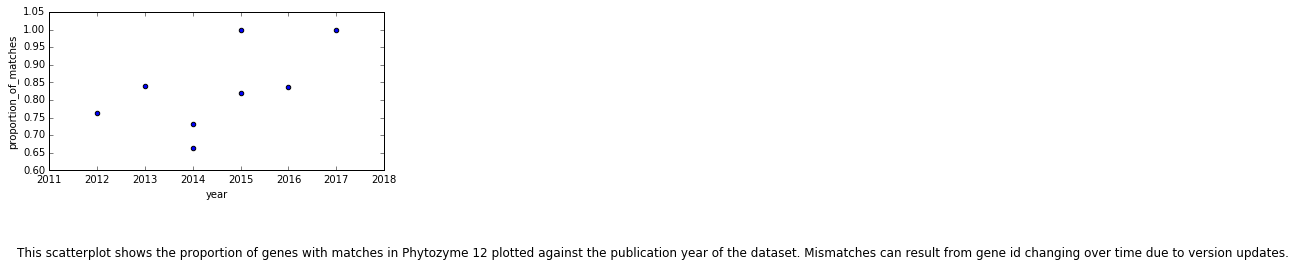

In [179]:
caption = "This scatterplot shows the proportion of genes with matches in Phytozyme 12 plotted against the publication year of the dataset. Mismatches can result from gene id changing over time due to version updates."

print(match_summary.columns)
match_summary['year'] = pd.to_numeric(match_summary['year'])
print(match_summary.dtypes)

fig = plt.figure()
match_summary.plot(x= 'year', y = 'proportion_of_matches', kind = "scatter")
plt.ticklabel_format(useOffset=False)
plt.subplots_adjust(bottom=0.35)
plt.figtext(0.05, 0.05,caption, fontsize=12, ha = 'left', wrap = True );

#Figure output is saved to analysis/generate_intermediate_data_02/ folder
plt.savefig("p_matches_versus_publication_year.png")